In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

import string

%matplotlib inline

In [2]:
def get_hour(item):
    return item.hour

def get_day_frame(directory, date, remove_zeros=True, cutoff_area=10000, dropna_thres=4,
                  parse_filename=False, find_cumtime=True,
                  col_names = ['Interval', 'x', 'y', 'Area', 'Hour', 'Minute', 'Second']):
    """
    Returns the day frame for all files in the directory
    date: (month, date, year) tuple, for adding the relevant columns
    parse_filename: set True for files without timestamp, will infer timestamps from filename
    find_cumtime: set False for files that have intervals that are cumulative instead of dt
    """
    files = glob.glob(directory + '/*.csv') 
    
    if files == []:
        return None
    
    frames = []
    for filename in files:
        obs = pd.read_csv(filename, header=None, names=col_names)
        
        # Remove nan columns
        obs.dropna(thresh=dropna_thres)
        
        # Parse filename to get time of the record
        if parse_filename:
            components = string.split(filename, '_')
            timestr = string.join(components[1:], ':')[:-4]
            endtime = pd.to_datetime(timestr)
            
            
            if find_cumtime:
                cum_time = np.cumsum(obs.Interval)
            else:
                cum_time = obs.Interval
            
            cum_time_delta = pd.to_timedelta(cum_time, unit='s')
            starttime = endtime - cum_time_delta[obs.shape[0] - 1]
            obs['Time'] = starttime + cum_time_delta
        
                 
        frames.append(obs)

    # Concatenate readings from all files
    day_frame = pd.concat(frames)
    day_frame['Day'] = date[1]
    day_frame['Month'] = date[0]
    day_frame['Year'] = date[2]
    
    if not parse_filename:
        day_frame['Time'] = pd.to_datetime(day_frame[['Day','Month', 'Year','Hour','Minute','Second']])
    
    # Light hour is from 9am to 7pm
    day_frame['Light'] = (day_frame.Time.apply(get_hour) >= 7) & (day_frame.Time.apply(get_hour) <= 21)
    
    # Remove zeros if specified
    if remove_zeros:
        day_frame = day_frame[(day_frame['x'] != 0) & (day_frame['y'] != 0)]
        
    # Remove entries which exceed a cutoff area
    if cutoff_area != None:
        day_frame = day_frame[day_frame.Area < cutoff_area]
        
    
    
    return day_frame
  

def collect_all_days(parent_dir, days, remove_zeros=True, cutoff_area=10000, dropna_thres=4,
                  parse_filename=False, find_cumtime=True,
                  col_names = ['Interval', 'x', 'y', 'Area', 'Hour', 'Minute', 'Second']):
    '''
    ------------------------
    Inputs:
    parent_dir: string indicating parent directory
    days: list of recording days
    ------------------------
    Output:
    A pd frame for all observations of that animal
    ------------------------    
    '''
    frames = []
    for day in days:
        #datestr = str(day[0]) + '/' + str(day[1]) + '/' + str(day[2])
        #datetime = pd.to_datetime(datestr)
        directory = parent_dir + day.strftime('%m%d') + '/'
        print directory
        if os.path.isdir(directory):
            day_frame = get_day_frame(directory, (day.month, day.day, day.year),
                                     remove_zeros, cutoff_area, dropna_thres,
                                     parse_filename, find_cumtime, col_names)
            frames.append(day_frame)
        else:
            print '     Directory does not exist'
    
    return pd.concat(frames)

In [3]:
def get_displacement(day_frame):
    '''
    Get displacement from x and y coords
    '''
    dx = np.diff(day_frame['x'])
    dy = np.diff(day_frame['y'])
    displacement = np.sqrt(dx * dx + dy * dy)
    
    # Diff returns n-1 values, so concatenate a 0 behind and make a new column
    return np.concatenate((displacement, [0])) 

def get_zeit(day_frame, start_time_str=None, use_time_field=False):
    '''
    Compute the zeitgeber time, starting from 9am, in unit of hours
    '''
    timeseries = day_frame.Time
    
    if start_time_str == None:
        starttime = timeseries[0]
    else:
        starttime = pd.to_datetime(start_time_str)

    return (timeseries - starttime) / pd.Timedelta(1, unit='h')

def plot_all_data(frame, axis):
    '''
    Make a plot of all displacement values
    '''
    axis.plot(frame['ZeitTime'], frame['Displacement'], '.', alpha=0.3)
    axis.fill_between(frame.ZeitTime, 0, axis.get_ylim()[1], 
                    where=~frame.Light, color='gray',  alpha=0.3)
    axis.set_xlabel('Zeitbeger time (h)')
    axis.set_ylabel('Displacement (pix)')
    
def ecdf(data):
    return np.sort(data), np.arange(len(data)) / float(len(data))

def aggregate_activity(day_frame, time, unit, axis=None, plot=False,
                      name='Bird', save=False):
    """
    Unit: either 'Hour', 'Minute', or 'Second'
    If plot set to True, also plot the activity
    Returns a data frame which is the total distance travelled in time * unit time specified
    """
    if unit == 'Hour':
        scale = 3600
    elif unit == 'Minute':
        scale = 60
    elif unit == 'Second':
        scale = 1
    else:
        raise ValueError('Invalid time unit')
        
    group_duration = time * scale # Number of seconds to group
    SECS_PER_DAY = 3600 * 24
    
    # ZeitTime is measured in hours, partitioned into groups of
    # specified group_duration
    group = (day_frame['ZeitTime'] / (group_duration/3600.0)).astype('int')
    agg_displacement = day_frame['Displacement'].groupby(group)
    
    agg_sum_grouped = agg_displacement.sum()
    
    # Create data frame with day information
    day = agg_sum_grouped.index / int(SECS_PER_DAY / group_duration)
    time_in_day = agg_sum_grouped.index % int(SECS_PER_DAY / group_duration)
    
    activity = pd.DataFrame.from_items([('Period', time_in_day), 
                                                 ('Activity', agg_sum_grouped), ('Day', day)])
    
    # Produce a plot if instructed
    if plot:
        for day in activity.Day.unique():
            activity_day = activity.Activity[activity.Day == day]
            time_in_day = activity.Period[activity.Day == day] /3
            axis.plot(time_in_day, activity_day)
        axis.set_xlabel('Time (hour)')
        axis.set_ylabel('Total distance in 20 minutes')
    
    # Save the frame when instructed
    if save:
        activity['Animal'] = name
        activity['Bin duration - ' + unit ] = time
        save_filename = 'Binned_results/' + name + '_binned.csv'
        if not os.path.isfile(save_filename):
            activity.to_csv(save_filename)
        else:
            raise IOError('File exists, cannot overwrite...')
    
    return activity

In [44]:
def process_animal(name, start_day_str, start_time_str=' 7:00AM', ndays=5,  
                   time=20, unit='Minute', save=False):
    '''
    Perform the analysis procedure for the specified animal
    name: string for name of animal, will read from folder of the same name
    start_day_str: string that represents start day, e.g. '9/25/2016'
    periods: number of days to read
    save: indicates whether the final frame should be saved to a .csv
    '''
    days = pd.date_range(start_day_str, periods=ndays, freq='d')
    frame_all = collect_all_days(name + '/', days)

    # Calculate displacement and zeitbeger time
    frame_all['Displacement'] = get_displacement(frame_all)
    frame_all['ZeitTime'] = get_zeit(frame_all, start_time_str=start_day_str + start_time_str)

    # Make plots of (1) all displacement points (2) binned activity, 20 minutes
    fig, ax = plt.subplots(1, 2, figsize=(18,10))
    plot_all_data(frame_all, ax[0])

    activity = aggregate_activity(frame_all, time=time, unit=unit, 
                                  plot=True, axis=ax[1], save=save, name=name)

2CW100/0925/
2CW100/0926/
2CW100/0927/
2CW100/0928/
2CW100/0929/


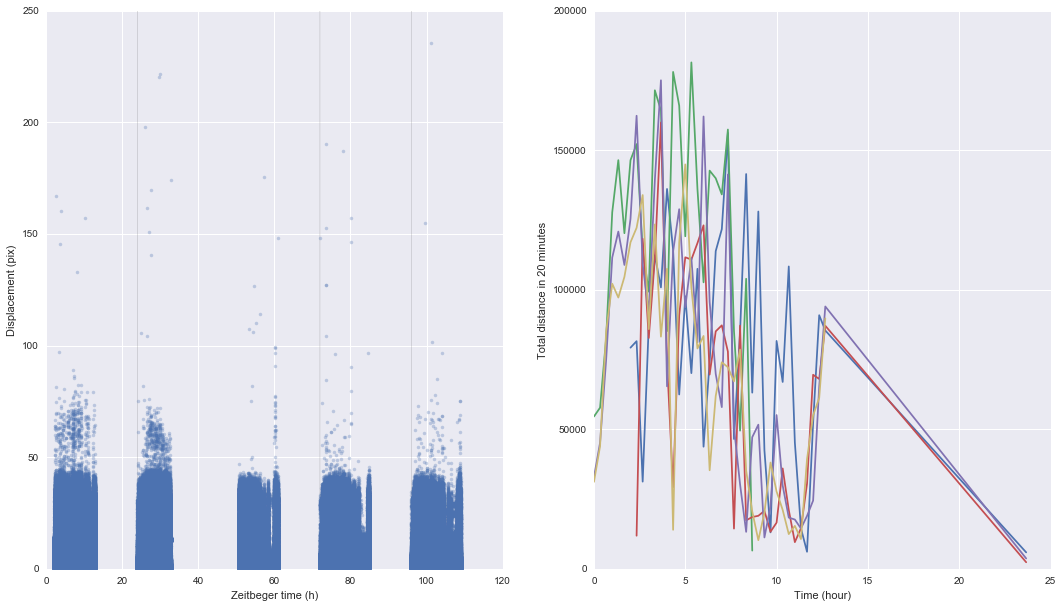

In [46]:
process_animal('2CW100', '9/25/2016', ndays=5, save=True)

In [ ]:
process_animal('2CW305', '9/25/2016', ndays=5, save=True)

In [ ]:
process_animal('2CW100', '9/25/2016', ndays=5, save=True)

In [ ]:
process_animal('2CW100', '9/25/2016', ndays=5, save=True)

In [ ]:
process_animal('2CW100', '9/25/2016', ndays=5, save=True)

In [ ]:
process_animal('2CW100', '9/25/2016', ndays=5, save=True)

In [ ]:
process_animal('2CW100', '9/25/2016', ndays=5, save=True)

In [ ]:
process_animal('2CW100', '9/25/2016', ndays=5, save=True)

In [ ]:
process_animal('2CW100', '9/25/2016', ndays=5, save=True)

2CW100/0925/
2CW100/0926/
2CW100/0927/
2CW100/0928/
2CW100/0929/


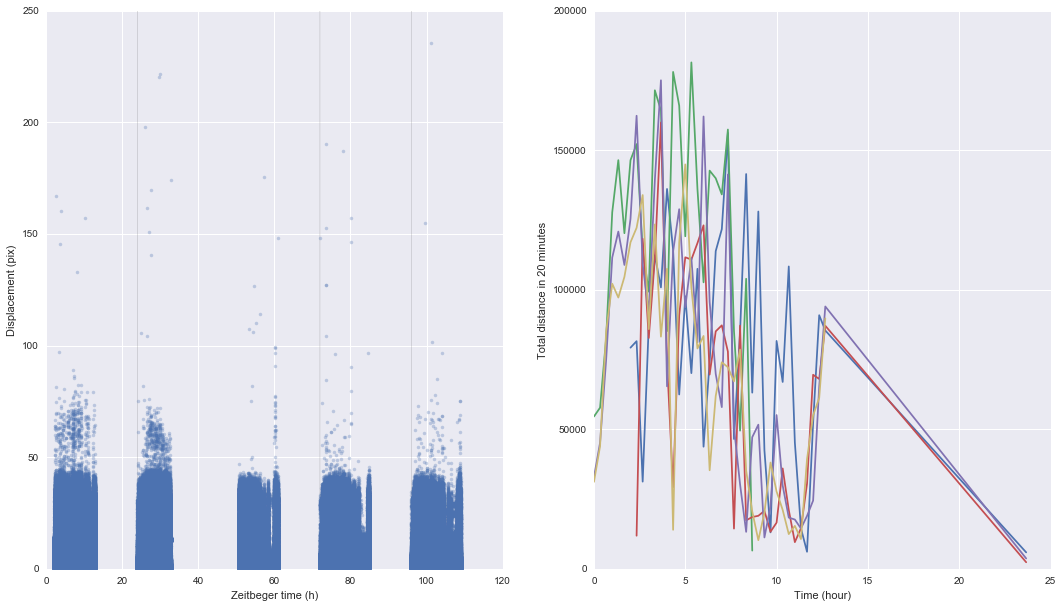

In [4]:
days = pd.date_range('9/25/2016', periods=5, freq='d')
frame_2CW100_all = collect_all_days('2CW100/', days)

# Calculate displacement and zeitbeger time
frame_2CW100_all['Displacement'] = get_displacement(frame_2CW100_all)
frame_2CW100_all['ZeitTime'] = get_zeit(frame_2CW100_all, start_time_str='9/25/2016 7:00AM')

# Make plots of (1) all displacement points (2) binned activity, 20 minutes
fig, ax = plt.subplots(1, 2, figsize=(18,10))
plot_all_data(frame_2CW100_all, ax[0])

activity = aggregate_activity(frame_2CW100_all, time=20, unit='Minute', 
                              plot=True, axis=ax[1], save=True, name='2CW100')

2CW305/0714/
2CW305/0715/
2CW305/0716/
2CW305/0717/


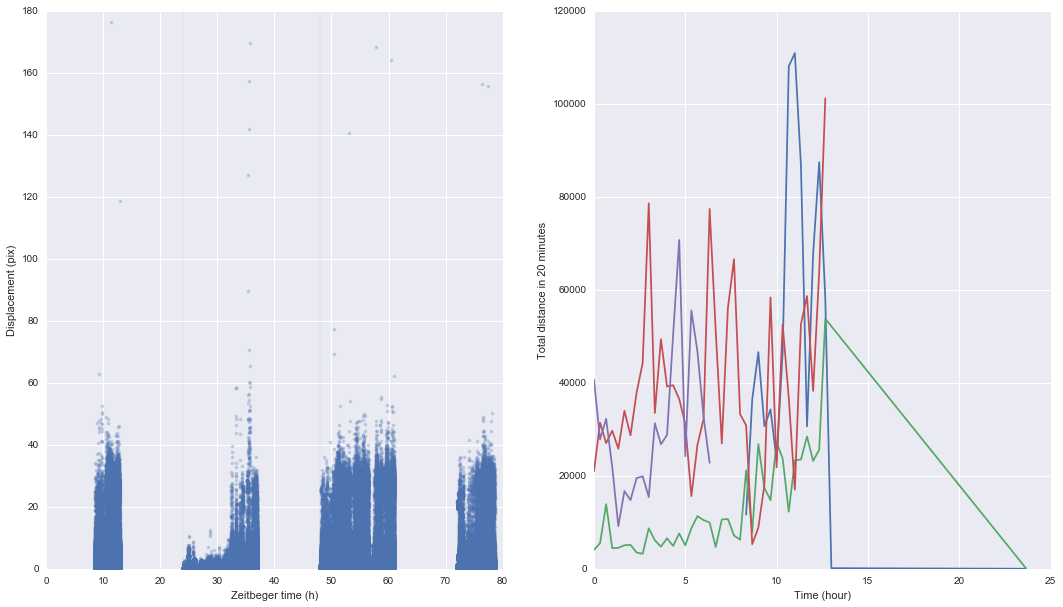

In [5]:
days = pd.date_range('7/14/2016', periods=4, freq='d')
frame_2CW305_all = collect_all_days('2CW305/', days, parse_filename=True)

frame_2CW305_all['Displacement'] = get_displacement(frame_2CW305_all)
frame_2CW305_all['ZeitTime'] = get_zeit(frame_2CW305_all, start_time_str='7/14/2016 7:00AM')

# Make plots of (1) all displacement points (2) binned activity, 20 minutes
fig, ax = plt.subplots(1, 2, figsize=(18,10))
plot_all_data(frame_2CW305_all, ax[0])

activity = aggregate_activity(frame_2CW305_all, time=20, unit='Minute', 
                              plot=True, axis=ax[1], save=True, name='2CW305')

In [36]:
frame_2CW318_all.sort_values(by='Time')

,Interval,x,y,Area,Hour,Minute,Second,Time,Day,Month,Year,Light,Displacement,ZeitTime
0,0.34287,80.821,61.762,NaN,NaN,NaN,NaN,2016-06-28 09:48:37.342870000,28,6,2016,True,4.488277,2.810373
1,0.87399,81.572,66.187,NaN,NaN,NaN,NaN,2016-06-28 09:48:37.873990000,28,6,2016,True,42.263599,2.810521
2,1.33610,122.710,56.498,NaN,NaN,NaN,NaN,2016-06-28 09:48:38.336100000,28,6,2016,True,0.341901,2.810649
3,1.50970,122.370,56.534,NaN,NaN,NaN,NaN,2016-06-28 09:48:38.509700000,28,6,2016,True,0.347851,2.810697
4,1.65590,122.700,56.644,NaN,NaN,NaN,NaN,2016-06-28 09:48:38.655900000,28,6,2016,True,0.085446,2.810738
5,1.77810,122.630,56.595,NaN,NaN,NaN,NaN,2016-06-28 09:48:38.778100000,28,6,2016,True,0.140513,2.810772
6,1.89510,122.770,56.583,NaN,NaN,NaN,NaN,2016-06-28 09:48:38.895100000,28,6,2016,True,0.074404,2.810804
7,2.00380,122.710,56.539,NaN,NaN,NaN,NaN,2016-06-28 09:48:39.003800000,28,6,2016,True,0.064622,2.810834
8,2.11280,122.770,56.563,NaN,NaN,NaN,NaN,2016-06-28 09:48:39.112800000,28,6,2016,True,0.027857,2.810865
9,2.23160,122.780,56.537,NaN,NaN,NaN,NaN,2016-06-28 09:48:39.231600000,28,6,2016,True,0.020616,2.810898


2CW318/0628/
2CW318/0629/
2CW318/0630/
2CW318/0701/


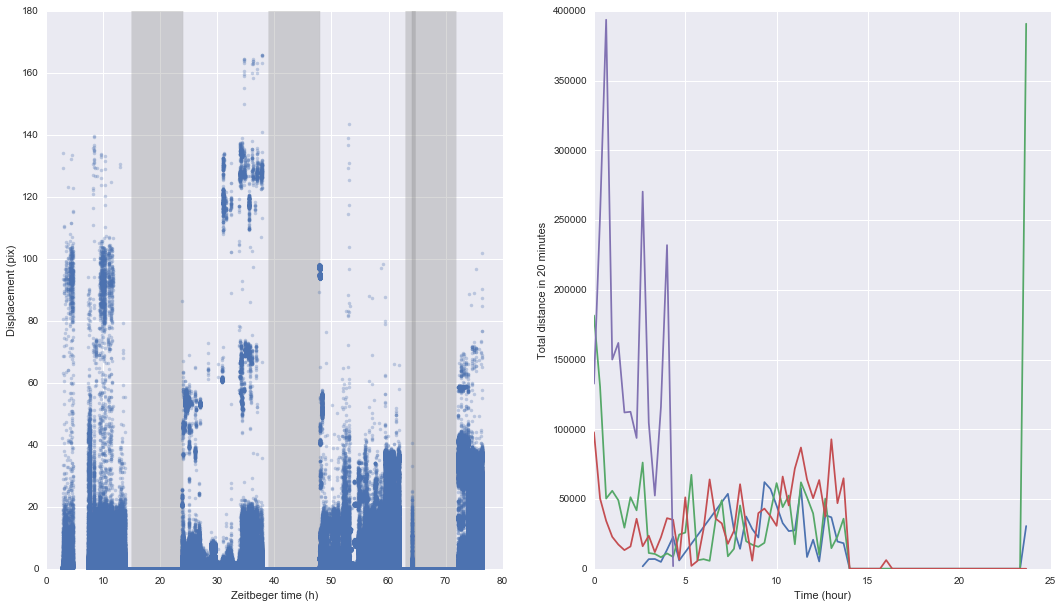

In [6]:
days = pd.date_range('6/28/2016', periods=4, freq='d')
frame_2CW318_all = collect_all_days('2CW318/', days, cutoff_area=None, parse_filename=True, find_cumtime=False)

frame_2CW318_all['Displacement'] = get_displacement(frame_2CW318_all)
frame_2CW318_all['ZeitTime'] = get_zeit(frame_2CW318_all, start_time_str='6/28/2016 7:00AM')

# Make plots of (1) all displacement points (2) binned activity, 20 minutes
fig, ax = plt.subplots(1, 2, figsize=(18,10))
plot_all_data(frame_2CW318_all, ax[0])

activity = aggregate_activity(frame_2CW318_all, time=20, unit='Minute', 
                              plot=True, axis=ax[1], save=True, name='2CW318')

LB21/0701/
LB21/0702/
LB21/0703/
LB21/0704/
LB21/0705/


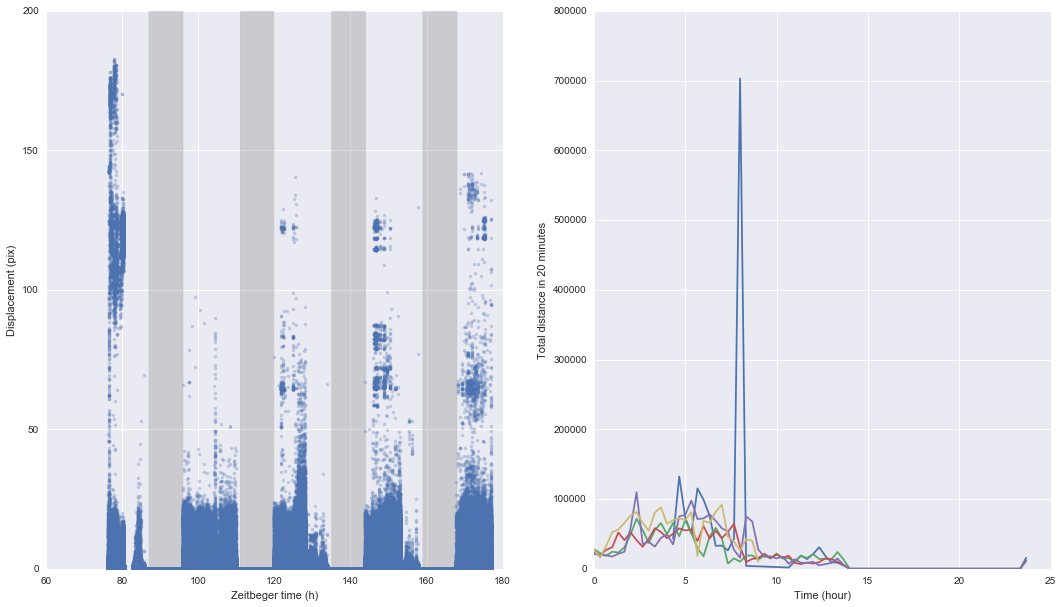

In [7]:
days = pd.date_range('7/1/2016', periods=5, freq='d')
frame_LB21_all = collect_all_days('LB21/', days, cutoff_area=None, parse_filename=True)

frame_LB21_all['Displacement'] = get_displacement(frame_LB21_all)
frame_LB21_all['ZeitTime'] = get_zeit(frame_LB21_all, start_time_str='6/28/2016 7:00AM')

# Make plots of (1) all displacement points (2) binned activity, 20 minutes
fig, ax = plt.subplots(1, 2, figsize=(18,10))
plot_all_data(frame_LB21_all, ax[0])

activity = aggregate_activity(frame_LB21_all, time=20, unit='Minute', 
                              plot=True, axis=ax[1], save=True, name='LB21')

In [10]:
frame_to_display = day_frame_0925

# Visualization of hourly patterns
fig, ax = plt.subplots(3, 3, figsize=(18,18))
ax_pos = [(x,y) for x in range(3) for y in range(3)] # list all positions on the grid

hour = 9
for coord in ax_pos:
    hour_frame = frame_to_display[frame_to_display['Hour'] == hour]
    ax[coord].plot(hour_frame['x'], hour_frame['y'])
    ax[coord].set_title('Activity in hour ' + str(hour))
    
    hour += 1

NameError: name 'day_frame_0925' is not defined

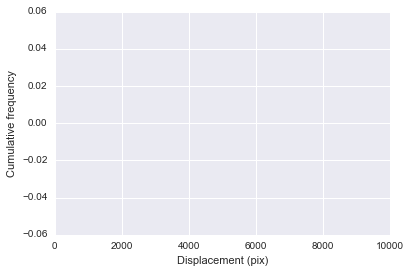

In [12]:
# Display the ecdf of all displacements
x, y = ecdf(frame_LB21_all.Area)
plt.plot(x, y)
plt.xlim((0,10000))
plt.xlabel('Displacement (pix)')
plt.ylabel('Cumulative frequency')

## Read and process all animals

2CW312/0709/
2CW312/0710/
2CW312/0711/
2CW312/0712/
2CW312/0713/
2CW312/0714/


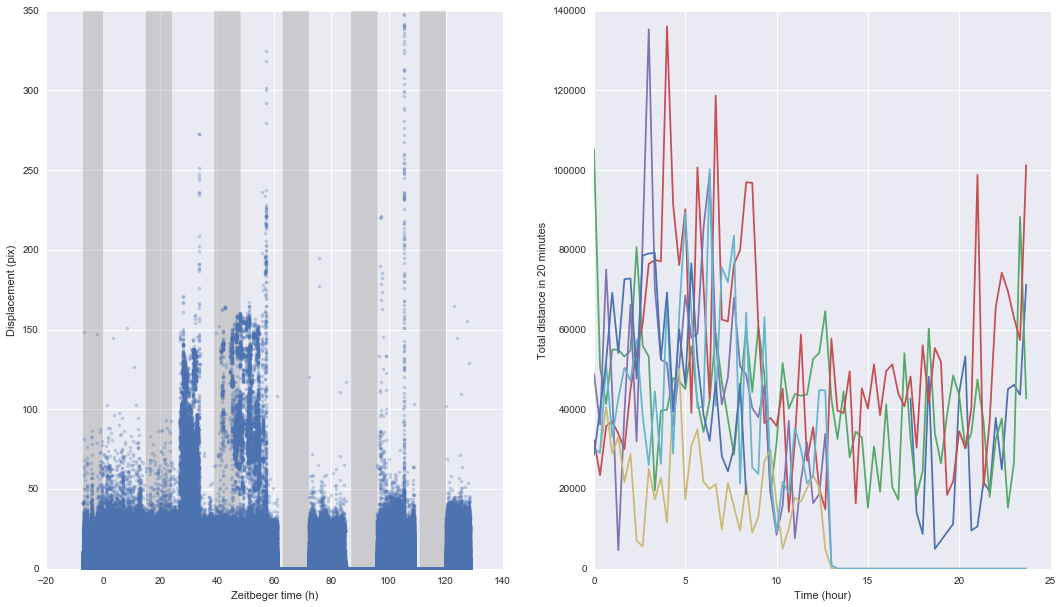

In [8]:
try:
    days = pd.date_range('7/9/2016', periods=6, freq='d')
    frame_2CW312_all = collect_all_days('2CW312/', days, cutoff_area=None, parse_filename=True)

    frame_2CW312_all['Displacement'] = get_displacement(frame_2CW312_all)
    frame_2CW312_all['ZeitTime'] = get_zeit(frame_2CW312_all, start_time_str='7/9/2016 7:00AM')

    # Make plots of (1) all displacement points (2) binned activity, 20 minutes
    fig, ax = plt.subplots(1, 2, figsize=(18,10))
    plot_all_data(frame_2CW312_all, ax[0])

    activity = aggregate_activity(frame_2CW312_all, time=20, unit='Minute', 
                                  plot=True, axis=ax[1], save=True, name='2CW312')
except:
    print '2CW312 error...'

LB15/0711/
LB15/0712/
LB15/0713/
LB15/0714/
LB15/0715/
     Directory does not exist


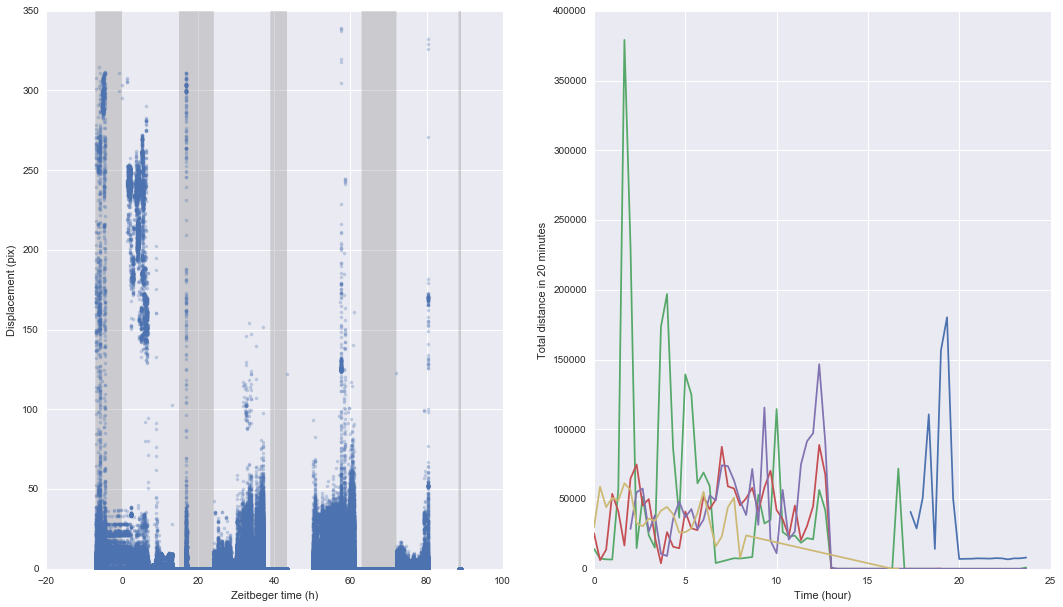

In [34]:
try:
    days = pd.date_range('7/11/2016', periods=5, freq='d')
    frame_LB15_all = collect_all_days('LB15/', days, cutoff_area=None, parse_filename=False)

    frame_LB15_all['Displacement'] = get_displacement(frame_LB15_all)
    frame_LB15_all['ZeitTime'] = get_zeit(frame_LB15_all, start_time_str='7/11/2016 7:00AM')

    # Make plots of (1) all displacement points (2) binned activity, 20 minutes
    fig, ax = plt.subplots(1, 2, figsize=(18,10))
    frame_LB15_all = frame_LB15_all.sort_values(by='ZeitTime')
    plot_all_data(frame_LB15_all, ax[0])

    activity = aggregate_activity(frame_LB15_all, time=20, unit='Minute', 
                                  plot=True, axis=ax[1], save=True, name='LB15')
except:
    print 'LB15 error...'

2CW306/0719/
2CW306/0720/
2CW306/0721/
2CW306/0722/


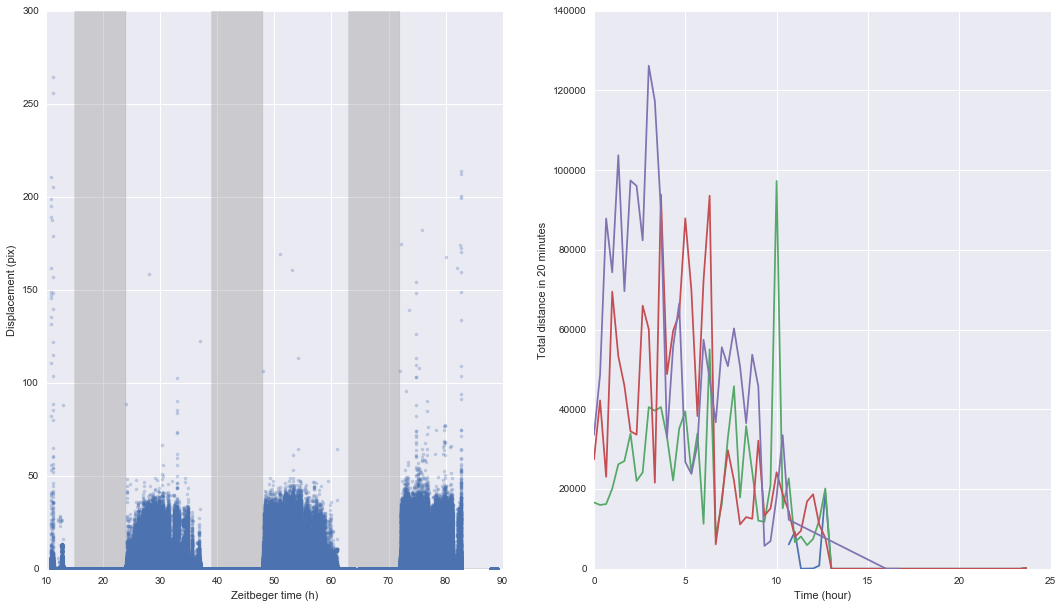

In [9]:
try:
    days = pd.date_range('7/19/2016', periods=4, freq='d')
    frame_2CW306_all = collect_all_days('2CW306/', days, cutoff_area=None, parse_filename=False)

    frame_2CW306_all['Displacement'] = get_displacement(frame_2CW306_all)
    frame_2CW306_all['ZeitTime'] = get_zeit(frame_2CW306_all, start_time_str='7/19/2016 7:00AM')

    # Make plots of (1) all displacement points (2) binned activity, 20 minutes
    fig, ax = plt.subplots(1, 2, figsize=(18,10))
    plot_all_data(frame_2CW306_all, ax[0])

    activity = aggregate_activity(frame_2CW306_all, time=20, unit='Minute', 
                                  plot=True, axis=ax[1], save=True, name='2CW306')
except:
    print '2CW306 error...'

2CW308/0714/
2CW308/0715/
2CW308/0716/
2CW308/0717/


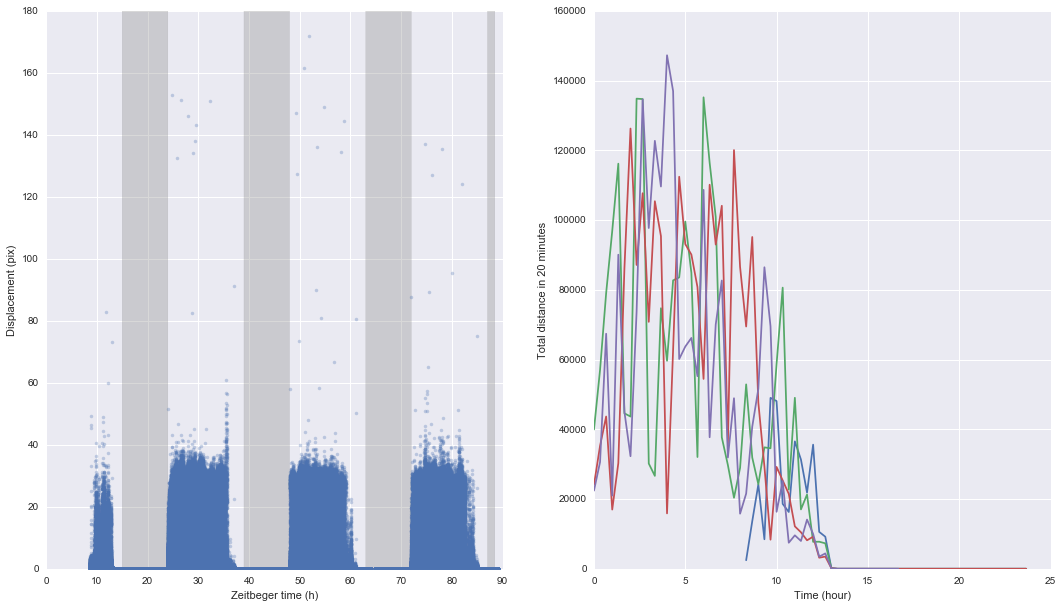

In [10]:
try:
    days = pd.date_range('7/14/2016', periods=4, freq='d')
    frame_2CW308_all = collect_all_days('2CW308/', days, cutoff_area=None, parse_filename=False)

    frame_2CW308_all['Displacement'] = get_displacement(frame_2CW308_all)
    frame_2CW308_all['ZeitTime'] = get_zeit(frame_2CW308_all, start_time_str='7/14/2016 7:00AM')

    # Make plots of (1) all displacement points (2) binned activity, 20 minutes
    fig, ax = plt.subplots(1, 2, figsize=(18,10))
    plot_all_data(frame_2CW308_all, ax[0])

    activity = aggregate_activity(frame_2CW308_all, time=20, unit='Minute', 
                                  plot=True, axis=ax[1], save=True, name='2CW308')
except:
    print '2CW308 error...'

LB06/0718/
LB06/0719/
LB06/0720/


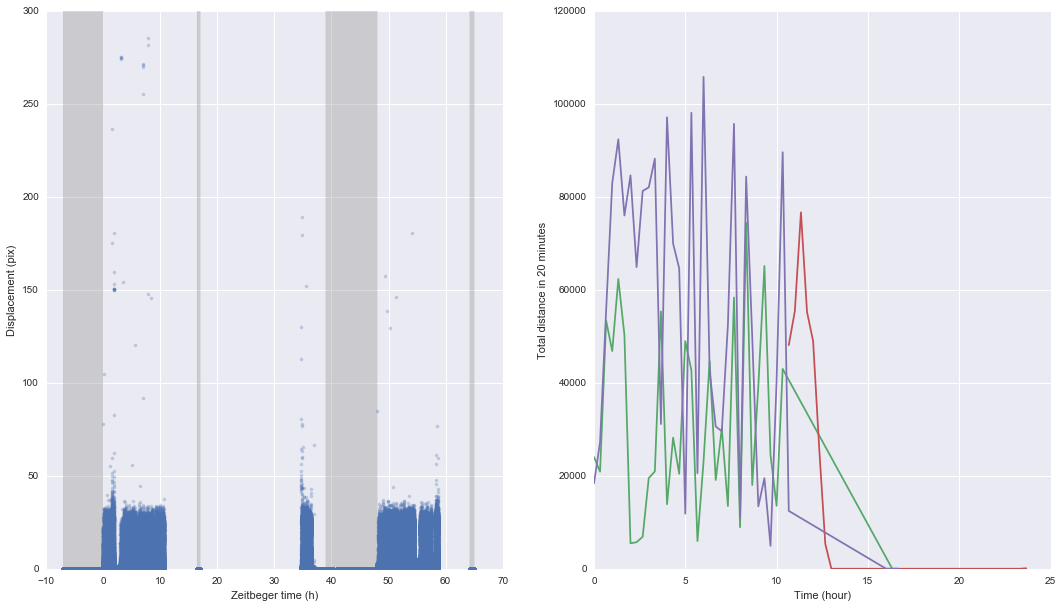

In [33]:
try:
    days = pd.date_range('7/18/2016', periods=3, freq='d')
    frame_LB06_all = collect_all_days('LB06/', days, cutoff_area=None, parse_filename=False)

    frame_LB06_all['Displacement'] = get_displacement(frame_LB06_all)
    frame_LB06_all['ZeitTime'] = get_zeit(frame_LB06_all, start_time_str='7/18/2016 7:00AM')

    # Make plots of (1) all displacement points (2) binned activity, 20 minutes
    fig, ax = plt.subplots(1, 2, figsize=(18,10))
    frame_LB06_all = frame_LB06_all.sort_values(by='ZeitTime')
    plot_all_data(frame_LB06_all, ax[0])

    activity = aggregate_activity(frame_LB06_all, time=20, unit='Minute', 
                                  plot=True, axis=ax[1], save=True, name='LB06')
except:
    print 'LB06 error...'

Or130/0722/
Or130/0723/
Or130/0724/
Or130/0725/
Or130/0726/
Or130/0727/
Or130/0728/


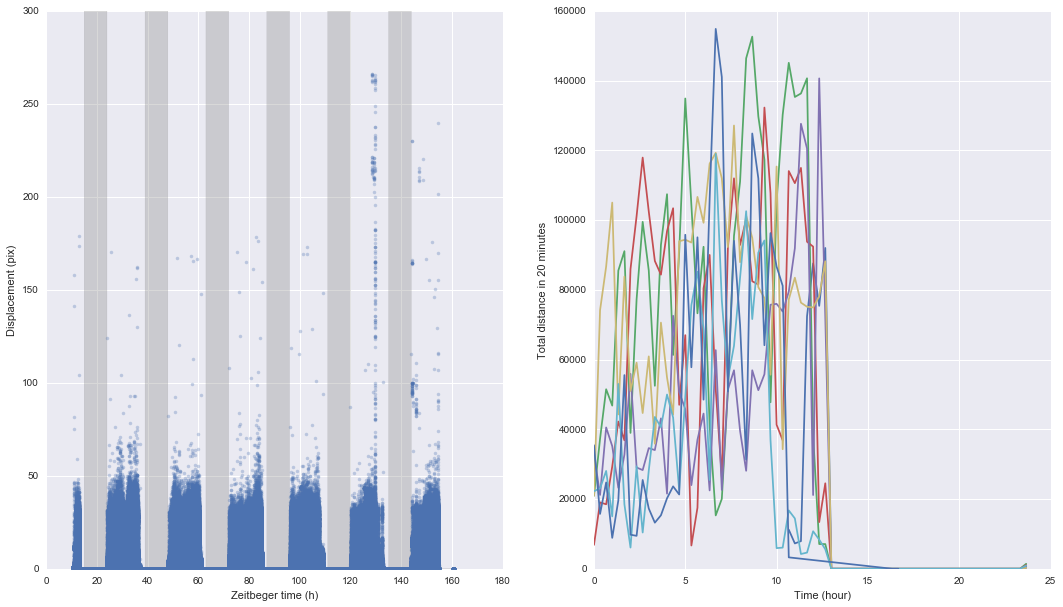

In [11]:
try:
    days = pd.date_range('7/22/2016', periods=7, freq='d')
    frame_Or130_all = collect_all_days('Or130/', days, cutoff_area=None, parse_filename=False)

    frame_Or130_all['Displacement'] = get_displacement(frame_Or130_all)
    frame_Or130_all['ZeitTime'] = get_zeit(frame_Or130_all, start_time_str='7/22/2016 7:00AM')

    # Make plots of (1) all displacement points (2) binned activity, 20 minutes
    fig, ax = plt.subplots(1, 2, figsize=(18,10))
    plot_all_data(frame_Or130_all, ax[0])

    activity = aggregate_activity(frame_Or130_all, time=20, unit='Minute', 
                                  plot=True, axis=ax[1], save=True, name='Or130')
except:
    print 'Or130 error...'

In [23]:
frame_Or114_all = frame_Or114_all.sort_values(by='ZeitTime')
plot_all_data(frame_Or114_all, ax[0])
activity = aggregate_activity(frame_Or114_all, time=20, unit='Minute', plot=True, axis=ax[1])

In [25]:
frame_Or114_all

,Interval,x,y,Area,Hour,Minute,Second,Day,Month,Year,Time,Light,Displacement,ZeitTime
16633,0.12119,160.5,90.5,57600,0,0,0.033,28,7,2016,2016-07-28 00:00:00.033,False,0.0,65.000009
16634,0.14156,160.5,90.5,57600,0,0,0.175,28,7,2016,2016-07-28 00:00:00.175,False,0.0,65.000049
16635,0.13529,160.5,90.5,57600,0,0,0.310,28,7,2016,2016-07-28 00:00:00.310,False,0.0,65.000086
16636,0.12152,160.5,90.5,57600,0,0,0.432,28,7,2016,2016-07-28 00:00:00.432,False,0.0,65.000120
16637,0.12574,160.5,90.5,57600,0,0,0.558,28,7,2016,2016-07-28 00:00:00.558,False,0.0,65.000155
16638,0.13681,160.5,90.5,57600,0,0,0.694,28,7,2016,2016-07-28 00:00:00.694,False,0.0,65.000193
16639,0.13683,160.5,90.5,57600,0,0,0.831,28,7,2016,2016-07-28 00:00:00.831,False,0.0,65.000231
16640,0.11306,160.5,90.5,57600,0,0,0.944,28,7,2016,2016-07-28 00:00:00.944,False,0.0,65.000262
16641,0.14346,160.5,90.5,57600,0,0,1.088,28,7,2016,2016-07-28 00:00:01.088,False,0.0,65.000302
16642,0.13321,160.5,90.5,57600,0,0,1.221,28,7,2016,2016-07-28 00:00:01.221,False,0.0,65.000339


In [17]:
frame_Or114_all

,Interval,x,y,Area,Hour,Minute,Second,Day,Month,Year,Time,Light,Displacement,ZeitTime
0,0.148390,163.37,111.49,557,10,36,54.677,28,7,2016,2016-07-28 10:36:54.677,True,16.012511,75.615188
1,0.104020,178.83,115.66,564,10,36,54.781,28,7,2016,2016-07-28 10:36:54.781,True,11.593882,75.615217
2,0.044033,190.42,115.36,551,10,36,54.825,28,7,2016,2016-07-28 10:36:54.825,True,0.986002,75.615229
3,0.048517,189.63,115.95,576,10,36,54.874,28,7,2016,2016-07-28 10:36:54.874,True,0.342053,75.615243
4,0.095452,189.90,115.74,567,10,36,54.980,28,7,2016,2016-07-28 10:36:54.980,True,0.588218,75.615272
5,0.046790,189.34,115.92,586,10,36,55.027,28,7,2016,2016-07-28 10:36:55.027,True,0.766094,75.615285
6,0.039942,188.72,116.37,603,10,36,55.067,28,7,2016,2016-07-28 10:36:55.067,True,0.170294,75.615296
7,0.043620,188.73,116.20,593,10,36,55.111,28,7,2016,2016-07-28 10:36:55.111,True,0.941488,75.615309
8,0.047396,188.93,115.28,576,10,36,55.158,28,7,2016,2016-07-28 10:36:55.158,True,0.340000,75.615322
9,0.040828,188.93,114.94,578,10,36,55.199,28,7,2016,2016-07-28 10:36:55.199,True,0.040000,75.615333


Or114/0726/
Or114/0727/
Or114/0728/
Or114/0729/
Or114/0730/
Or114/0731/
     Directory does not exist
Or114/0801/
Or114/0802/
Or114/0803/


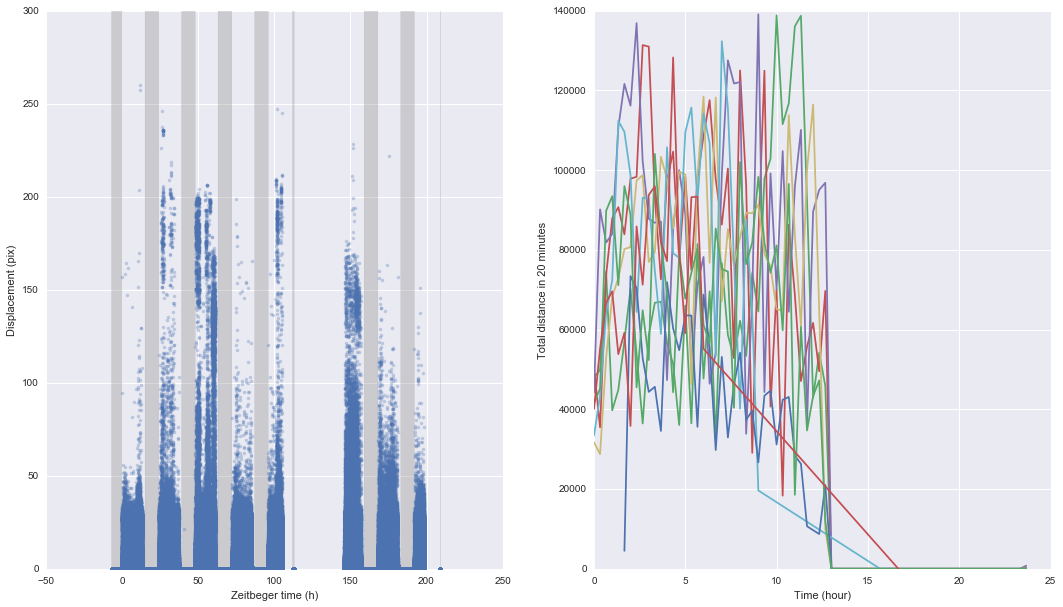

In [26]:
try:
    days = pd.date_range('7/26/2016', periods=9, freq='d')
    frame_Or114_all = collect_all_days('Or114/', days, cutoff_area=None, parse_filename=False)

    frame_Or114_all['Displacement'] = get_displacement(frame_Or114_all)
    frame_Or114_all['ZeitTime'] = get_zeit(frame_Or114_all, start_time_str='7/26/2016 7:00AM')

    # Make plots of (1) all displacement points (2) binned activity, 20 minutes
    fig, ax = plt.subplots(1, 2, figsize=(18,10))
    frame_Or114_all = frame_Or114_all.sort_values(by='ZeitTime')
    plot_all_data(frame_Or114_all, ax[0])

    activity = aggregate_activity(frame_Or114_all, time=20, unit='Minute', 
                              plot=True, axis=ax[1], save=True, name='Or114')
except:
    print 'Or114 error...'

2CW317/0720/
2CW317/0721/
2CW317/0722/
2CW317/0723/
2CW317/0724/
2CW317/0725/
2CW317 error...


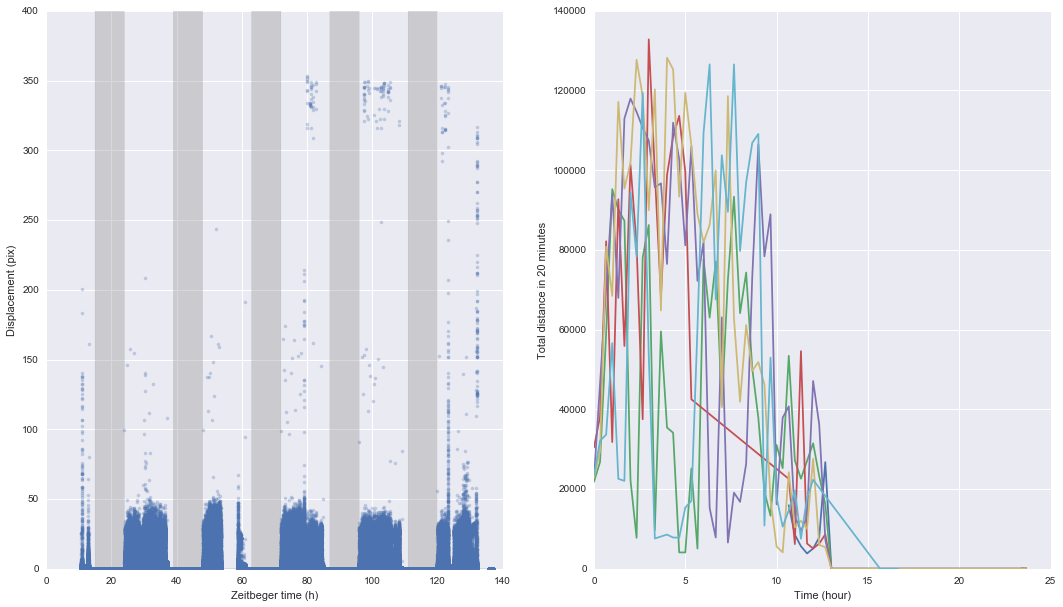

In [36]:
try:
    days = pd.date_range('7/20/2016', periods=6, freq='d')
    frame_2CW317_all = collect_all_days('2CW317/', days, cutoff_area=None, parse_filename=False)

    frame_2CW317_all['Displacement'] = get_displacement(frame_2CW317_all)
    frame_2CW317_all['ZeitTime'] = get_zeit(frame_2CW317_all, start_time_str='7/20/2016 7:00AM')

    # Make plots of (1) all displacement points (2) binned activity, 20 minutes
    fig, ax = plt.subplots(1, 2, figsize=(18,10))
    plot_all_data(frame_2CW317_all, ax[0])

    activity = aggregate_activity(frame_2CW317_all, time=20, unit='Minute', 
                                  plot=True, axis=ax[1], save=True, name='2CW317')
except:
    print '2CW317 error...'

Z1Pi229/0803/
Z1Pi229/0804/
Z1Pi229/0805/
Z1Pi229/0806/
Z1Pi229/0807/
Z1Pi229/0808/
Z1Pi229/0809/
Z1Pi229/0810/
Z1Pi229/0811/
Z1Pi229/0812/
Z1Pi229/0813/
Z1Pi229/0814/
Z1Pi229/0815/
Z1Pi229/0816/
Z1Pi229/0817/


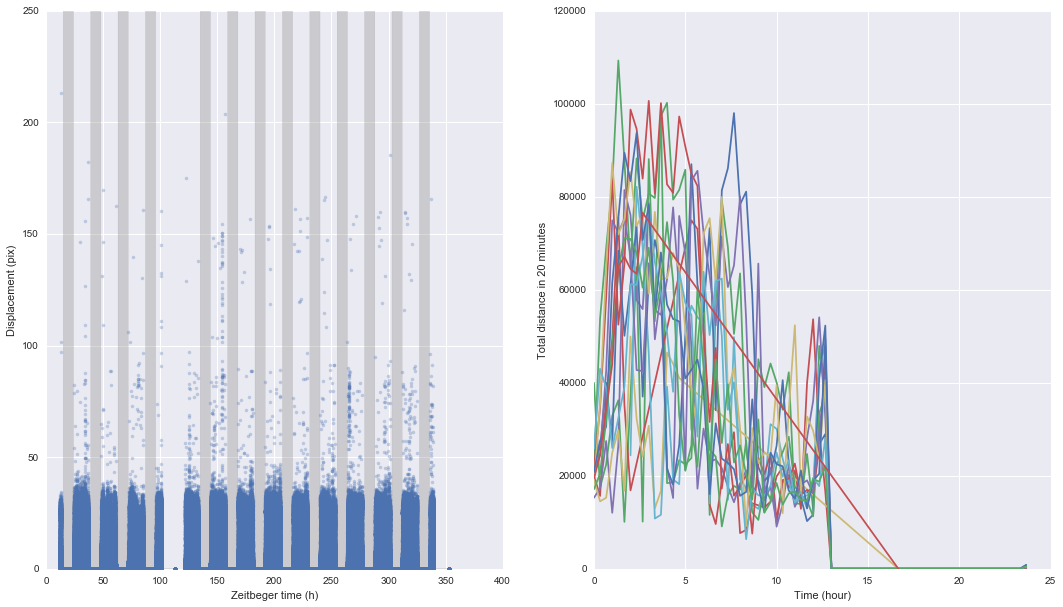

In [13]:
try:
    days = pd.date_range('8/3/2016', periods=15, freq='d')
    frame_Z1Pi229_all = collect_all_days('Z1Pi229/', days, cutoff_area=None, parse_filename=False)

    frame_Z1Pi229_all['Displacement'] = get_displacement(frame_Z1Pi229_all)
    frame_Z1Pi229_all['ZeitTime'] = get_zeit(frame_Z1Pi229_all, start_time_str='8/3/2016 7:00AM')

    # Make plots of (1) all displacement points (2) binned activity, 20 minutes
    fig, ax = plt.subplots(1, 2, figsize=(18,10))
    plot_all_data(frame_Z1Pi229_all, ax[0])

    activity = aggregate_activity(frame_Z1Pi229_all, time=20, unit='Minute', 
                                  plot=True, axis=ax[1], save=True, name='Z1Pi229')
except:
    print 'Z1Pi229 error...'

Z1Pi230/0803/
Z1Pi230/0804/
Z1Pi230/0805/
Z1Pi230/0806/
Z1Pi230/0807/
     Directory does not exist
Z1Pi230/0808/
Z1Pi230/0809/
Z1Pi230/0810/
Z1Pi230/0811/
Z1Pi230/0812/
Z1Pi230/0813/
Z1Pi230/0814/
Z1Pi230/0815/


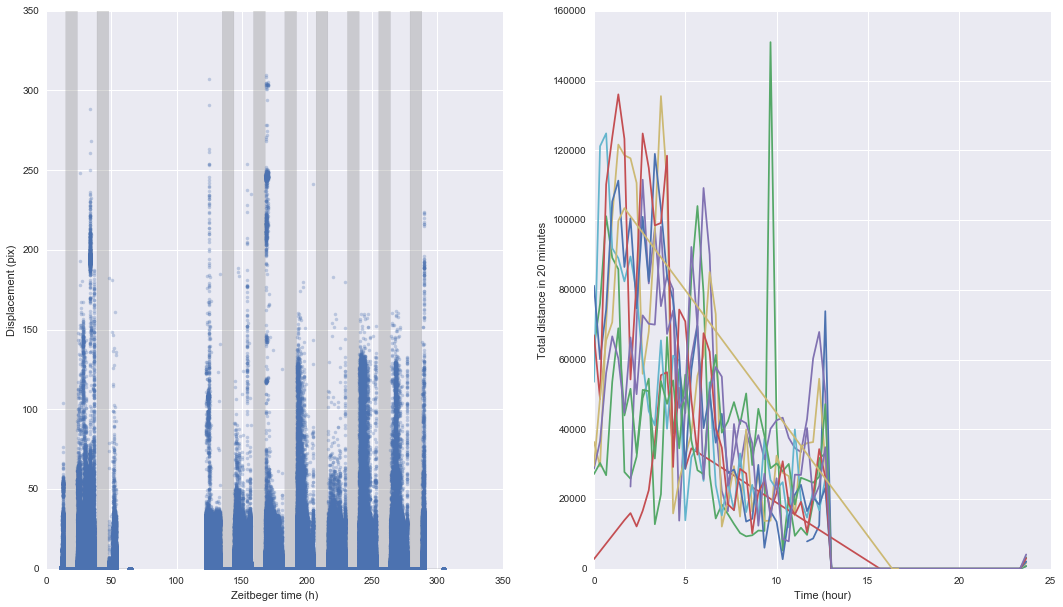

In [12]:
try:
    days = pd.date_range('8/3/2016', periods=13, freq='d')
    frame_Z1Pi230_all = collect_all_days('Z1Pi230/', days, cutoff_area=None, parse_filename=False)

    frame_Z1Pi230_all['Displacement'] = get_displacement(frame_Z1Pi230_all)
    frame_Z1Pi230_all['ZeitTime'] = get_zeit(frame_Z1Pi230_all, start_time_str='8/3/2016 7:00AM')

    # Make plots of (1) all displacement points (2) binned activity, 20 minutes
    fig, ax = plt.subplots(1, 2, figsize=(18,10))
    plot_all_data(frame_Z1Pi230_all, ax[0])

    activity = aggregate_activity(frame_Z1Pi230_all, time=20, unit='Minute', 
                                  plot=True, axis=ax[1], save=True, name='Z1Pi230')
except:
    print 'Z1Pi230 error...'

In [26]:
glob.glob('Z1Pi229/0803/*.txt')

[]

In [31]:
activity.Period.unique()

array([35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 49, 50], dtype=int64)

In [34]:
activity.to_csv('test.csv')